# Project 3: Custom FL Benchmark and Performance Evaluation

Create a custom federated learning (FL) benchmark using non-traditional datasets and evaluate existing FL algorithms on it. Unlike previous projects, you have more freedom, and grading will focus on the quality of your benchmark design, experiments, and analysis. Clear explanations, discussions, and code are essential for full credit. Include experiment results in your final submission.

1. Propose a method for constructing IID and non-IID datasets in your field of study or research, excluding image classification tasks.
- 1.1. Provide a detailed descrip1on of the dataset (e.g., size, labels, configuration, etc.). (5 points)
- 1.2. Describe how to construct the IID dataset. (10 points)
- 1.3. Describe how to construct the non-IID dataset. (20 points)

2. Based on the dataset configurations in Part 1, apply federated learning (FL) and compare the performances.
- 2.1. Explain the loss function for the task and the model architecture used for training. (5 points)
- 2.2. Specify the FL algorithm(s) used without FedAvg algorithm. (30 points)
- 2.3. Present a table of experimental results and analyze them (30 points). At least two in-depth analyses are required.

Examples of in-depth analysis you can conduct include:
- Comparing performance between IID and non-IID datasets.
- Evaluating the effects of full par1cipa1on vs. par1al client par1cipa1on.
- Analyzing the impact of varying the total number of clients.
- Fine-tuning hyperparameters for different FL algorithms.

Submission Requirements:
- All code must be submitted and should function without any errors.
- For each problem, include explanations of which func1ons in your code perform the specified tasks. You must either reference the function names explicitly or provide screenshots of the relevant code lines.
- Ensure that the code is well-documented and reproducible.

Report Format:
- The report must follow the NeurIPS paper format. However, you do not need to strictly adhere to every detail of the style guide.

Note: Even if you are unable to implement the tasks in code, you can s9ll receive par9al credit by providing detailed ideas and explana9ons in your report.

Submit your iPython file named: 'Project3_AIGS_(student_ID)_(your name).ipynb', e.g., 'Project3_AIGS_20221234_Gildong_Hong.ipynb'.

### Library Imports

In [1]:
import os
import time
import pickle
import random
from typing import Union, Callable, Optional, List, Dict
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from einops import rearrange
from einops.layers.torch import Rearrange
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = ""
os.getcwd()

'/root/dev/playground/practice/federated_learning'

### Client Network Declarations

I re-implemented the dance classifier based on the original [EDGE](https://arxiv.org/abs/2211.10658) model, which is a generative model for dance generation task.

In [2]:
from rotary_embedding_torch import RotaryEmbedding
from modules import (
    PositionalEncoding, TransformerEncoderLayer, SinusoidalPosEmb,
    FiLMTransformerDecoderLayer, DecoderLayerStack, prob_mask_like
)

# data coefficients
pos_dim, rot_dim = 3, 24*6
repr_dim = pos_dim + rot_dim + 4
num_classes = 10 # 10 for AIST++, 16 for FineDance -> integrated into 10
horizon_seconds, FPS = 5, 30
seq_len = horizon_seconds * FPS

cond_feature_dim = 35 # 35 for librosa, 4800 for jukebox

# TransformerEncoderLayer coefficients
latent_dim = 512
num_layers = 8
num_heads = 8
ff_size = 1024
dropout = 0.1
activation = F.gelu
batch_first = True
use_rotary = True

In [3]:
class DanceClsNet(nn.Module):
    def __init__(
        self,
        nfeats: int,
        num_classes: int,
        seq_len: int = 150,
        latent_dim: int = 256,
        ff_size: int = 1024,
        num_layers: int = 4,
        num_heads: int = 4,
        dropout: float = 0.1,
        cond_feature_dim: int = 4800, # 4800 for jukebox, 35 for librosa
        activation: Callable[[Tensor], Tensor] = F.gelu,
        use_rotary=True,
        **kwargs,
    ) -> None:
        super().__init__()
        
        # positional embeddings
        self.rotary = None
        self.abs_pos_encoding = nn.Identity()
        if use_rotary:
            self.rotary = RotaryEmbedding(dim=latent_dim)
        else:
            self.abs_pos_encoding = PositionalEncoding(latent_dim, dropout, batch_first=True)
        
        # time embedding processing -> all timesteps will be given as 0.
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(latent_dim),  # learned?
            nn.Linear(latent_dim, latent_dim * 4),
            nn.Mish(),
        )

        self.to_time_cond = nn.Sequential(nn.Linear(latent_dim * 4, latent_dim),)

        self.to_time_tokens = nn.Sequential(
            nn.Linear(latent_dim * 4, latent_dim * 2),  # 2 time tokens
            Rearrange("b (r d) -> b r d", r=2),
        )
        
        self.norm_cond = nn.LayerNorm(latent_dim)
        
        # input (motion) projection
        self.input_projection = nn.Linear(nfeats, latent_dim)
        
        # conditional (music) projection
        self.cond_projection = nn.Linear(cond_feature_dim, latent_dim)
        self.non_attn_cond_projection = nn.Sequential(
            nn.LayerNorm(latent_dim), nn.Linear(latent_dim, latent_dim), nn.SiLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        self.cond_encoder = nn.Sequential()
        for _ in range(2):
            self.cond_encoder.append(TransformerEncoderLayer(
                d_model=latent_dim, nhead=num_heads, dim_feedforward=ff_size, dropout=dropout,
                activation=activation, batch_first=True, rotary=self.rotary
            ))
        
        # decoder
        decoderstack = nn.ModuleList([])
        for _ in range(num_layers):
            decoderstack.append(FiLMTransformerDecoderLayer(
                latent_dim, num_heads, dim_feedforward=ff_size, dropout=dropout,
                activation=activation, batch_first=True, rotary=self.rotary
            ))
        
        self.seq_trans_decoder = DecoderLayerStack(decoderstack)
        
        # classification head
        self.final_layer = nn.Sequential(
            nn.LayerNorm(latent_dim), nn.Linear(latent_dim, num_classes)
        )
        self.classifier = nn.Sequential(
            nn.Linear(seq_len*num_classes, seq_len*num_classes // 2),
            nn.Linear(seq_len*num_classes // 2, num_classes)
        )
    
    def forward(self, x, cond):
        B, device = x.shape[0], x.device
        
        x = self.abs_pos_encoding(self.input_projection(x))
        cond_tokens = self.cond_encoder(self.abs_pos_encoding(self.cond_projection(cond)))
        cond_hidden = self.non_attn_cond_projection(cond_tokens.mean(dim=-2)) # mean pooled tokens to hidden
        
        times = torch.zeros((B,), device=device).long()
        t_hidden = self.time_mlp(times)
        t = self.to_time_cond(t_hidden)
        t_tokens = self.to_time_tokens(t_hidden)
        
        t += cond_hidden
        
        c = torch.cat((cond_tokens, t_tokens), dim=-2)
        cond_tokens = self.norm_cond(c)
        
        out = self.seq_trans_decoder(x, cond_tokens, t)
        out = self.final_layer(out)
        out = self.classifier(rearrange(out, "b n c -> b (n c)")) # (B, N, num_classes) -> (B, num_classes)
        return out

### Dataloaders and Data Partitioning Functions

More details in dataloader.py

In [4]:
from dataloader import DanceDataset, load_dataloaders

In [5]:
GENRES_AIST = {
    'gBR': 0, # Break
    'gPO': 1, # Pop
    'gLO': 2, # Lock
    'gMH': 3, # Middle Hiphop
    'gLH': 4, # LA-style Hiphop
    'gHO': 5,
    'gWA': 6,
    'gKR': 7,
    'gJS': 8,
    'gJB': 9,
}

GENRES_FINEDANCE = {
    'Breaking': 0,
    'Popping': 1,
    'Locking': 2,
    'Hiphop':3,
    'Urban':4,
    'Jazz':5,
    'jazz':5,

    'Tai':6,
    'Uighur':7,
    'Hmong':8,
    'Dai':6,
    'Wei':7,
    'Miao':8,

    'HanTang':9,
    'ShenYun':10,
    'Kun':11,
    'DunHuang':12,

    'Korean':13,
    'Choreography':14,
    'Chinese':15,
}

In [6]:
# AISTPP (30FPS)
batch_size = 16
num_workers = 4
dataset_path = "datasets/MambaDance"
data_name = "AISTPP_30FPS"
seq_len = 150
stride = 15
wav_path = "datasets/MambaDance"
aist_split_path = "datasets/aistpp_splits"

train_aist = DanceDataset(
    split="train",
    dataset_path=dataset_path,
    data_name=data_name,
    seq_len=seq_len,
    stride=stride,
    num_windows=None,
    wav_path=wav_path,
    aist_split_path=aist_split_path,
    finedance_partial=None
)
valid_aist = DanceDataset(
    split="valid",
    dataset_path=dataset_path,
    data_name=data_name,
    seq_len=seq_len,
    stride=stride,
    num_windows=None,
    wav_path=wav_path,
    aist_split_path=aist_split_path,
    finedance_partial=None
)

# # FineDance (30FPS)
# batch_size = 128
# num_workers = 8
# dataset_path = "datasets/MambaDance"
# data_name = "FINEDANCE"
# seq_len = 1024
# num_windows = 5
# wav_path = "datasets/MambaDance/FINEDANCE/music_wav"
# finedance_partial = "full"

# train_finedance = DanceDataset(
#     split="train",
#     dataset_path=dataset_path,
#     data_name=data_name,
#     seq_len=seq_len,
#     stride=None,
#     num_windows=num_windows,
#     wav_path=wav_path,
#     aist_split_path=None,
#     finedance_partial=finedance_partial
# )
# valid_finedance = DanceDataset(
#     split="valid",
#     dataset_path=dataset_path,
#     data_name=data_name,
#     seq_len=seq_len,
#     stride=None,
#     num_windows=num_windows,
#     wav_path=wav_path,
#     aist_split_path=None,
#     finedance_partial=finedance_partial
# )

100%|█████████████████████████████████████████████████████████████████████████████| 980/980 [00:00<00:00, 1446.48it/s]


Loaded AISTPP_30FPS which has 17677 samples...


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 7282.41it/s]

Loaded AISTPP_30FPS which has 190 samples...


In [7]:
def create_iid_partitions(dataset, num_clients=100):
    num_items_per_client = len(dataset) // num_clients
    all_indices = np.arange(len(dataset))
    np.random.shuffle(all_indices)

    client_data_indices = {i: all_indices[i * num_items_per_client:(i + 1) * num_items_per_client]
                           for i in range(num_clients)}

    return client_data_indices

def create_non_iid_partitions(dataset, num_clients=100, shards_per_client=2):
    num_shards = num_clients * shards_per_client
    shard_size = len(dataset) // num_shards
    targets = np.array(list(data["genre"].item() for i, data in enumerate(dataset)))
    data_indices_by_label = np.argsort(targets)

    shards = [data_indices_by_label[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
    random.shuffle(shards)

    client_data_indices = {}
    for client_id in range(num_clients):
        client_shards = shards[client_id * shards_per_client:(client_id + 1) * shards_per_client]
        client_data_indices[client_id] = np.concatenate(client_shards)

    return client_data_indices

- Example usage of 'create_iid_partitions' and create_non_iid_partitions'

In [8]:
num_clients = 100
iid_partitions = create_iid_partitions(train_aist, num_clients)
non_iid_partitions = create_non_iid_partitions(train_aist, num_clients)

# Data for client 0 (IID and Non-IID)
client_0_iid_data = torch.utils.data.Subset(train_aist, iid_partitions[0])
client_0_non_iid_data = torch.utils.data.Subset(train_aist, non_iid_partitions[0])

# Sanity check
client_0_iid_labels = []
for i, data in enumerate(client_0_iid_data):
    client_0_iid_labels.append(data["genre"].item())
client_0_iid_labels = set(client_0_iid_labels)

client_0_non_iid_labels = []
for i, data in enumerate(client_0_non_iid_data):
    client_0_non_iid_labels.append(data["genre"].item())
client_0_non_iid_labels = set(client_0_non_iid_labels)

print(f'Client 0 (IID) data size: {len(client_0_iid_data)}, labels: {client_0_iid_labels}')
print(f'Client 0 (Non-IID) data size: {len(client_0_non_iid_data)}, labels: {client_0_non_iid_labels}')

Client 0 (IID) data size: 176, labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Client 0 (Non-IID) data size: 176, labels: {4, 6}


# 1. AIST++ Dataset Experiments

## 1) Implementing FedAvg Algorithm

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            motion, music = batch["motion"].to(device), batch["music"].to(device)
            target, wav = batch["genre"].to(device), batch["wav"]
            output = model(motion, music)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(target)
    return correct / total

### FedAvg Algorithm on AIST++ Dataset Splits

In [10]:
# FedAvg algorithm for MNIST dataset splits
def federated_avg_dance(global_model, train_dataset, test_dataset, train_dataset_indices, C, E, B, lr, \
                        target_acc=0.99, run_to_max_rounds=False, max_rounds=600, verbose=False, verbose_step=10):
    """
    Perform federated averaging.

    :param global_model: Global model to be trained
    :param train_dataset_indices: Data partitioned across clients
    :param C: Fraction of clients per round
    :param E: Number of local epochs per client
    :param B: Batch size for local training
    :param lr: Learning rate for SGD
    :param target_acc: Target accuracy for stopping criterion
    :param run_to_max_rounds: Flag indicating whether to run until maximum rounds (True) or stop at convergence (False)
    :param verbose: Flag managing verbose loggings.

    Modifications to the function header MUST NOT be made in any sense, i.e. do not change any arguments.
    The return value MUST be a numpy array containing test accuracies of global models for each round.
    """

    # An example skeleton code
    selected_clients = max(1, int(C * 100))  # Number of clients selected per round

    test_loader = DataLoader(test_dataset, batch_size=B, shuffle=False, pin_memory=True, num_workers=4)
    test_accuracies = []

    for i in range(max_rounds):
        # Randomly select clients, create a new client instance, run local SGD updates on the client's dataset,
        # and gather the updated model weights.
        # training
        sampled_clients = random.sample(list(train_dataset_indices.keys()), selected_clients)
        client_weights = []
        for client_id in sampled_clients:
            client_indices = train_dataset_indices[client_id]
            
            client_dataset = Subset(train_dataset, client_indices)
            client_loader = DataLoader(client_dataset, batch_size=B, shuffle=True)
            
            client_model = DanceClsNet(
                nfeats=repr_dim, num_classes=num_classes, seq_len=seq_len,
                latent_dim=latent_dim, ff_size=ff_size, num_layers=num_layers, num_heads=num_heads,
                dropout=dropout, cond_feature_dim=cond_feature_dim, activation=activation
            )
            client_model.load_state_dict(global_model.state_dict())
            client_model.to(device)
            
            client_optimizer = optim.SGD(client_model.parameters(), lr=lr)
            
            client_model.train()
            for epoch in range(E):
                for batch in client_loader:
                    motion, music = batch["motion"].to(device), batch["music"].to(device)
                    target, wav = batch["genre"].to(device), batch["wav"]
                    client_optimizer.zero_grad()
                    output = client_model(motion, music)
                    loss = nn.CrossEntropyLoss()(output, rearrange(target, "b 1 -> b"))
                    loss.backward()
                    client_optimizer.step()
            client_weights.append(client_model.state_dict())
        
        global_state_dict = global_model.state_dict()
        avg_weights = {key: torch.zeros_like(val) for key, val in global_state_dict.items()}
        
        for client_state in client_weights:
            for key in avg_weights.keys():
                avg_weights[key] += client_state[key] / len(client_weights)
        
        global_model.load_state_dict(avg_weights)
        
        # evaluation
        test_accuracy = evaluate_model(global_model, test_loader)
        if verbose and (i+1) % verbose_step == 0:
            print(f'Round {i+1}/{max_rounds}, Test Accuracy: {test_accuracy:.4f}')
        test_accuracies.append(test_accuracy)

        if not run_to_max_rounds and test_accuracy >= target_acc:
            return np.array(test_accuracies)

    return np.array(test_accuracies)

#### Calculating Communication Rounds to Achieve Target Accuracy

In [ ]:
iid_partitions = create_iid_partitions(train_aist)
non_iid_partitions = create_non_iid_partitions(train_aist)

rounds_for_convergence = np.zeros((2, 5))
invariant_configs = {'E': 5, 'B': 128, 'lr': 0.004, 'target_acc': 0.60, \
        'train_dataset': train_aist, 'test_dataset': valid_aist, 'verbose': True}
client_portions = [0.0, 0.5, 1.0]

training_args = dict(invariant_configs)

if (os.path.exists(f'{save_dir}results_mnist_convergence.npy')):
    try:
        intermediate_results = np.load(f'{save_dir}results_mnist_convergence.npy')
        assert rounds_for_convergence.shape == intermediate_results.shape
        rounds_for_convergence = intermediate_results
    except Exception as e:
        print('Failed on loading intermediate results. Conducting experiments from scratch...')
        print(e)

training_args.update({'train_dataset_indices': iid_partitions})

print(f'Dance Classification IID Experiment (C=0)------------------------------------')
global_model = DanceClsNet(
    nfeats=repr_dim, num_classes=num_classes, seq_len=seq_len,
    latent_dim=latent_dim, ff_size=ff_size, num_layers=num_layers, num_heads=num_heads,
    dropout=dropout, cond_feature_dim=cond_feature_dim, activation=activation
).to(device)
training_args.update({'C': 0, 'global_model': global_model})
rounds_for_convergence[0][0] = len(federated_avg_dance(**training_args))
np.save(f'{save_dir}results_mnist_convergence.npy', rounds_for_convergence)

training_args.update({'train_dataset_indices': non_iid_partitions})
for i, C in enumerate(client_portions):
    if (rounds_for_convergence[1][i] > 0):
        continue
    print(f'Dance Classification non-IID Experiment (C={C})------------------------------------')
    global_model = DanceClsNet(
        nfeats=repr_dim, num_classes=num_classes, seq_len=seq_len,
        latent_dim=latent_dim, ff_size=ff_size, num_layers=num_layers, num_heads=num_heads,
        dropout=dropout, cond_feature_dim=cond_feature_dim, activation=activation
    ).to(device)
    training_args.update({'C': C, 'global_model': global_model})
    rounds_for_convergence[1][i] = len(federated_avg_dance(**training_args))
    np.save(f'{save_dir}results_mnist_convergence.npy', rounds_for_convergence)

print('All experiments with varying configurations have completed successfully.')

Dance Classification IID Experiment (C=0)------------------------------------
Round 10/600, Test Accuracy: 0.0895
Round 20/600, Test Accuracy: 0.2526
Round 30/600, Test Accuracy: 0.2053
Round 40/600, Test Accuracy: 0.3053
Round 50/600, Test Accuracy: 0.3368
Round 60/600, Test Accuracy: 0.2842
Round 70/600, Test Accuracy: 0.1316
Round 80/600, Test Accuracy: 0.2632
Round 90/600, Test Accuracy: 0.1526
Round 100/600, Test Accuracy: 0.1579
Round 110/600, Test Accuracy: 0.1053
Round 120/600, Test Accuracy: 0.1632
Round 130/600, Test Accuracy: 0.2632
Round 140/600, Test Accuracy: 0.2526
Round 150/600, Test Accuracy: 0.2947
Round 160/600, Test Accuracy: 0.2158
Round 170/600, Test Accuracy: 0.3895
Round 180/600, Test Accuracy: 0.3947
Round 190/600, Test Accuracy: 0.4316
Round 200/600, Test Accuracy: 0.4947
Round 210/600, Test Accuracy: 0.4158
Dance Classification non-IID Experiment (C=0.0)------------------------------------
Round 10/600, Test Accuracy: 0.0526
Round 20/600, Test Accuracy: 0.084

#### Result Collection
Once you have gathered the communication rounds needed for the server network to reach the target accuracy in the previous code cell, execute the code below to summarize the results.

In [ ]:
# print('Effect of the client fraction C on the communication rounds (AIST, E=5, B=10, target_acc=99%).\n')
# print('  Split  | C = 0.0 | C = 0.2 | C = 0.5 | C = 1.0 ')
# print('-----------------------------------------------------------')
# print('   IID   | %7d | %7d | %7d | %7d ' % tuple(rounds_for_convergence[0]))
# print(' non-IID | %7d | %7d | %7d | %7d ' % tuple(rounds_for_convergence[1]))

#### Discussion [10 pts]
Based on the results shown in the table above, write a brief one-paragraph discussion analyzing the effects of changing the client portion (`C`) on the communication rounds required to achieve target accuracy.

**Discussion:**

A) The results show that as the client portion ```C``` grows, the number of communication rounds required to ahieve the target accuracy generally decreases for both IID and non-IID data distributions. Specifically, for IID data, a larger client portion results in fewer rounds, suggesting better **convergence** with increased participation. In the non-IID case, there is a significant reduction in communication rounds from ```C=0``` to higher values, indicating that involving more clients helps mitigate the negative effects of data heterogeneity. Thus, higher the number of participating clients (```C```) stabilizes and accelerates convergence, especially in non-IID senarios.

# Implementing FL algorithms

In [7]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    #random.seed(seed)
seed_everything(0)

## Dirichlet distribution based Non-IID partition

In [8]:
def split_data_iid(dataset: Dataset, num_users: int) -> List[Subset]:
    num_items = len(dataset) // num_users
    indices = np.random.permutation(len(dataset))
    return [Subset(dataset, indices[i * num_items:(i + 1) * num_items]) for i in range(num_users)]

def split_data_non_iid(dataset: Dataset, num_users: int, alpha: float) -> List[Subset]:
    """Split dataset into Non-IID subsets for each user using Dirichlet distribution."""
    class_indices = defaultdict(list)

    # Group indices by class
    for idx, data in enumerate(dataset):
        class_indices[data["genre"].item()].append(idx)

    # Ensure each class is represented by its indices
    class_indices = {k: np.array(v) for k, v in class_indices.items()}

    # (1) Generate Dirichlet distribution probabilities
    dirichlet_dist = np.random.dirichlet([alpha] * num_users, num_classes)

    user_indices = [[] for _ in range(num_users)]
    for class_id, probabilities in enumerate(dirichlet_dist):
        class_idx = class_indices[class_id]
        np.random.shuffle(class_idx)  # Shuffle class indices

        # (2) Split indices based on Dirichlet probabilities, Ensure all indices are used
        split = np.array_split(class_idx, (probabilities * len(class_idx)).astype(int).cumsum()[:-1])
        split[-1] = np.concatenate([split[-1], class_idx[len(np.concatenate(split)):]])

        # (3) Using .extend function, compose each user's data into user_indices[user_id].
        for user_id, indices in enumerate(split): # Implement here!
            user_indices[user_id].extend(indices)


    # Create Subsets for each user
    return [Subset(dataset, indices) for indices in user_indices]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_loader = DataLoader(valid_aist, batch_size=batch_size, shuffle=False)

non_iid_data = split_data_non_iid(train_aist, 10, 0.5)
for i, user_data in enumerate(non_iid_data):
    labels = [train_aist[idx]["genre"].item() for idx in user_data.indices]
    print(f"User {i}: {len(user_data)} samples, Label distribution: {np.bincount(labels, minlength=10)}")

User 0: 821 samples, Label distribution: [ 67  94 387  20  66  93   6   6   9  73]
User 1: 1483 samples, Label distribution: [ 84   6 338 542  11 162 113   3 116 108]
User 2: 2101 samples, Label distribution: [ 40   9  30 596  54 243 115 229 785   0]
User 3: 2322 samples, Label distribution: [ 42 120  68 359 701 245 158 135  98 396]
User 4: 2097 samples, Label distribution: [196  30 227  42 338 105 566 151 223 219]
User 5: 2616 samples, Label distribution: [ 73  91  29  46 436 484  64 970  54 369]
User 6: 777 samples, Label distribution: [  1   0 319  53  40  29 324   0  11   0]
User 7: 1030 samples, Label distribution: [  0 173 149   2 236   0   3 157 233  77]
User 8: 2309 samples, Label distribution: [ 183 1120   17  172   32   78  207  213   17  270]
User 9: 2121 samples, Label distribution: [965  61 329 183 135  70  12  33   8 325]


## FL Algorithms

- FedAvgM
- FedProx
- SCAFFOLD

In [9]:
class User:
    def __init__(self, user_id: int, model: nn.Module, data: Dataset, lr: float, method: str, mu: float):
        self.user_id = user_id
        self.model = model
        self.data = data
        self.lr = lr
        self.method = method
        self.mu = mu
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.c_local = {name: torch.zeros_like(param) for name, param in self.model.state_dict().items()}

    def train(self, global_model: nn.Module, epochs: int, global_control: Dict[str, torch.Tensor] = {"None": torch.Tensor(0)}):
        """Train the local model."""
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()
        global_params = {name: param.clone().detach() for name, param in global_model.state_dict().items()}
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

        train_loader = DataLoader(self.data, batch_size=batch_size, shuffle=True)
        total_loss = 0.0

        # You can use this variable to implement SCAFFOLD.
        delta_c_local = {name: torch.zeros_like(param) for name, param in self.c_local.items()}

        for epoch in range(epochs):
            for batch in train_loader:
                motion, music = batch["motion"].to(self.device), batch["music"].to(self.device)
                target, wav = batch["genre"].to(self.device), batch["wav"]
                optimizer.zero_grad()
                outputs = self.model(motion, music)
                loss = criterion(outputs, rearrange(target, "b 1 -> b"))

                # (2) FedProx
                if self.method == 'FedProx':
                    # Implement FedProx here.
                    prox_loss = 0.
                    for name, param in self.model.state_dict().items():
                        prox_loss += ((param - global_params[name]) ** 2).sum()
                    loss += (self.mu / 2) * prox_loss

                # (3)SCAFFOLD
                elif self.method == 'SCAFFOLD':
                    # (3-1) Implement SCAFFOLD
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            param.grad += self.c_local[name] - global_control[name]
                        # else:
                        #     print(f"[Warning] the gradient of {name}: {param.grad}")

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

        # Update delta_c_local for SCAFFOLD
        if self.method == 'SCAFFOLD':
            # (3-2) Implement SCAFFOLD
            for name in delta_c_local:
                delta_c_local[name] = global_params[name] - self.model.state_dict()[name]

        avg_loss = total_loss / (len(train_loader) * epochs)

        return self.model.state_dict(), delta_c_local, avg_loss

# Define the Server class
class Server:
    def __init__(self, model: nn.Module, users: List[User], method: str, momentum: float):
        self.global_model = model
        self.users = users
        self.method = method
        self.momentum = momentum
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.global_model.to(self.device)

        # FedAvgM momentum state
        self.momentum_buffer = {name: torch.zeros_like(param) for name, param in self.global_model.state_dict().items()}

        # SCAFFOLD c_global
        self.c_global = {name: torch.zeros_like(param) for name, param in self.global_model.state_dict().items()}


    def select_users(self, fraction: float):
        num_selected = max(1, int(fraction * len(self.users)))
        return np.random.choice(self.users, num_selected, replace=False)

    def aggregate(self, updates: List[Dict[str, torch.Tensor]], delta_cs: List[Dict[str, torch.Tensor]] = [{"None": torch.Tensor(0)}]):

        avg_update = {name: torch.zeros_like(param) for name, param in updates[0].items()}

        if self.method in ['FedAvg', 'FedAvgM']:
            for update in updates:
                for name, param in update.items():
                    avg_update[name] += param / len(updates)

            if self.method == 'FedAvgM':
                # (1) FedAvgM
                # Implement FedAvgM here. You may use the self.momentum_buffer variable.
                for name in avg_update:
                    self.momentum_buffer[name] = self.momentum * self.momentum_buffer[name] + avg_update[name]
                    avg_update[name] = -(self.global_model.state_dict()[name] - self.momentum_buffer[name])

            self.global_model.load_state_dict(avg_update)

        elif self.method == 'FedProx':
            # FedProx uses FedAvg-style aggregation
            for update in updates:
                for name, param in update.items():
                    avg_update[name] += param / len(updates)
            self.global_model.load_state_dict(avg_update)

        elif self.method == 'SCAFFOLD':
            for update in updates:
                for name, param in update.items():
                    avg_update[name] += param / len(updates)

            self.global_model.load_state_dict(avg_update)

            # Update c_global for SCAFFOLD
            if self.method == 'SCAFFOLD' and delta_cs is not None:
                # (3-3) Implement SCAFFOLD.
                for name in self.c_global:
                    delta_c_global = sum(delta_c[name] for delta_c in delta_cs) / len(delta_cs)
                    self.c_global[name] += delta_c_global


    def evaluate(self, test_loader: DataLoader):
        self.global_model.eval()
        correct, total = 0, 0
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0

        with torch.no_grad():
            for batch in test_loader:
                motion, music = batch["motion"].to(self.device), batch["music"].to(self.device)
                target, wav = batch["genre"].to(self.device), batch["wav"]
                outputs = self.global_model(motion, music)
                loss = criterion(outputs, rearrange(target, "b 1 -> b"))
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target.view_as(predicted)).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(test_loader)
        return accuracy, avg_loss


def federated_learning(
    server: Server, rounds: int, epochs: int, fraction: float, test_loader: DataLoader
):
    avg_local_losses, global_losses, accuracies = [], [], []
    for round_num in range(rounds):
        print(f"Round {round_num + 1}/{rounds} starting...")
        selected_users = server.select_users(fraction)
        updates = []
        delta_cs = []  # For SCAFFOLD

        local_losses = []
        for user in selected_users:
            if server.method == 'SCAFFOLD':
                local_update, delta_c, local_loss = user.train(server.global_model, epochs, server.c_global)
                delta_cs.append(delta_c)
            else:
                local_update, _, local_loss = user.train(server.global_model, epochs)
            updates.append(local_update)
            local_losses.append(local_loss)

        avg_local_loss = sum(local_losses) / len(local_losses)
        avg_local_losses.append(avg_local_loss)

        if server.method == 'SCAFFOLD':
            server.aggregate(updates, delta_cs)
        else:
            server.aggregate(updates)
        accuracy, global_loss = server.evaluate(test_loader)
        accuracies.append(accuracy)
        global_losses.append(global_loss)
        print(f"Round {round_num + 1}/{rounds} completed.")
        print(f" Avg Local Loss: {avg_local_loss:.4f}")
        print(f" Global Loss: {global_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
        # save metrics iteratively
        np.savez(
            "metrics.npz", # test
            avg_local_losses=avg_local_losses,
            global_losses=global_losses,
            accuracies=accuracies
        )
    return avg_local_losses, global_losses, accuracies


def plot_metrics(avg_local_losses, global_losses, accuracies, rounds):
    """
    Plots avg_local_loss, global_loss, and accuracy over communication rounds.

    Args:
        avg_local_losses (list): Average local loss for each round.
        global_losses (list): Global loss for each round.
        accuracies (list): Accuracy for each round.
        rounds (int): Total number of communication rounds.
    """
    rounds_range = range(1, rounds + 1)

    # Plot avg_local_loss
    plt.figure(figsize=(10, 6))
    plt.plot(rounds_range, avg_local_losses, linestyle="-", label="Avg Local Loss")
    plt.xlabel("Communication Rounds")
    plt.ylabel("Avg Local Loss")
    plt.title("Average Local Loss per Round")
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot global_loss
    plt.figure(figsize=(10, 6))
    plt.plot(rounds_range, global_losses, linestyle="-", label="Global Loss", color='orange')
    plt.xlabel("Communication Rounds")
    plt.ylabel("Global Loss")
    plt.title("Global Loss per Round")
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(rounds_range, accuracies, linestyle="-", label="Accuracy", color='green')
    plt.xlabel("Communication Rounds")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Round")
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()


def federated_learning_with_scenario(
    server_class,
    user_class,
    global_model_class,
    dataset: Dataset,
    num_users: int,
    rounds: int,
    epochs: int,
    fraction: float,
    iid: bool,
    lr: float,
    alpha: float,
    test_loader: DataLoader,
    momentum: float,
    method: str,
    mu: float,
    model_kwargs,
):

    if iid:
        user_data = split_data_iid(dataset, num_users)
        print(f"Data split: IID with {num_users} users.")
    else:
        user_data = split_data_non_iid(dataset, num_users, alpha)
        print(f"Data split: Non-IID with {num_users} users (alpha={alpha}).")

    users = [
        user_class(user_id=i, model=global_model_class(**model_kwargs), data=user_data[i], lr=lr, method=method, mu=mu)
        for i in range(num_users)
    ]

    global_model = global_model_class(**model_kwargs)
    server = server_class(model=global_model, users=users, method=method, momentum=momentum)

    avg_local_losses, global_losses, accuracies = federated_learning(
        server, rounds, epochs, fraction, test_loader
    )
    
    # plot results
    plot_metrics(avg_local_losses, global_losses, accuracies, rounds)

In [10]:
num_users = 20
fraction = 0.4
rounds = 200
iid = False
alpha = 0.5

model_kwargs = {
    "nfeats": repr_dim,
    "num_classes": num_classes,
    "seq_len": seq_len,
    "latent_dim": latent_dim,
    "ff_size": ff_size,
    "num_layers": num_layers,
    "num_heads": num_heads,
    "dropout": dropout,
    "cond_feature_dim": cond_feature_dim,
    "activation": activation
}

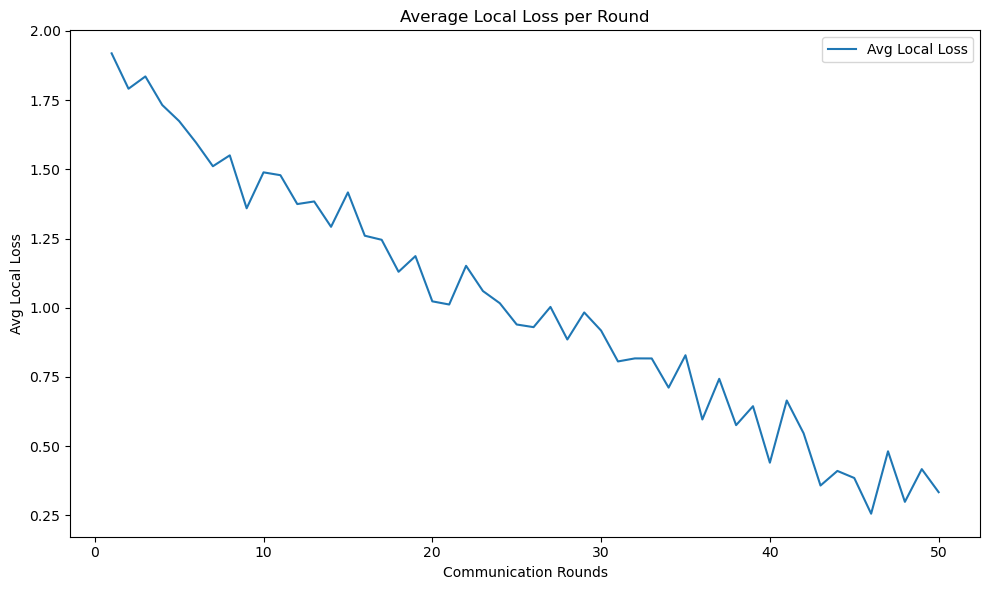

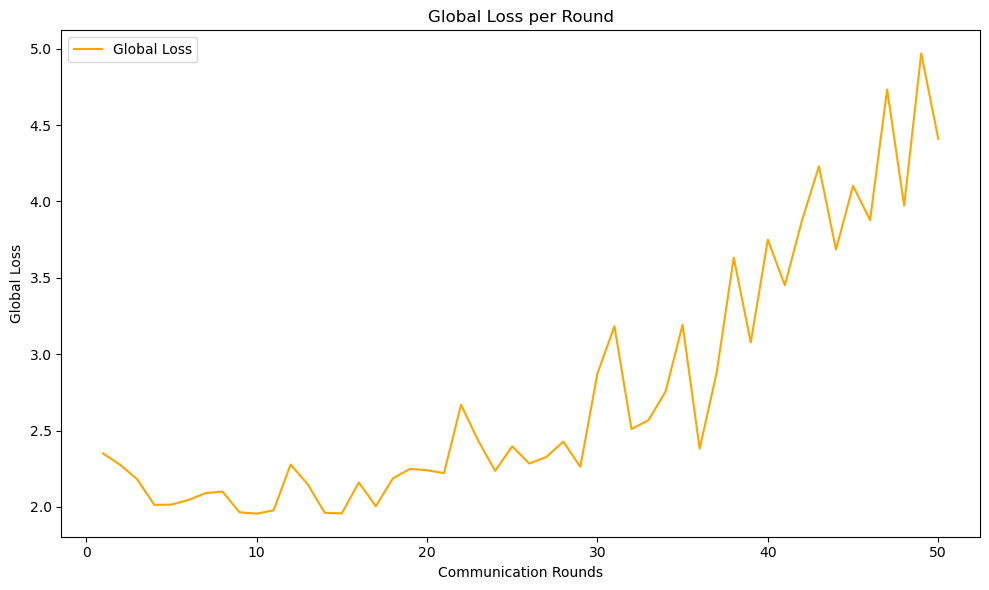

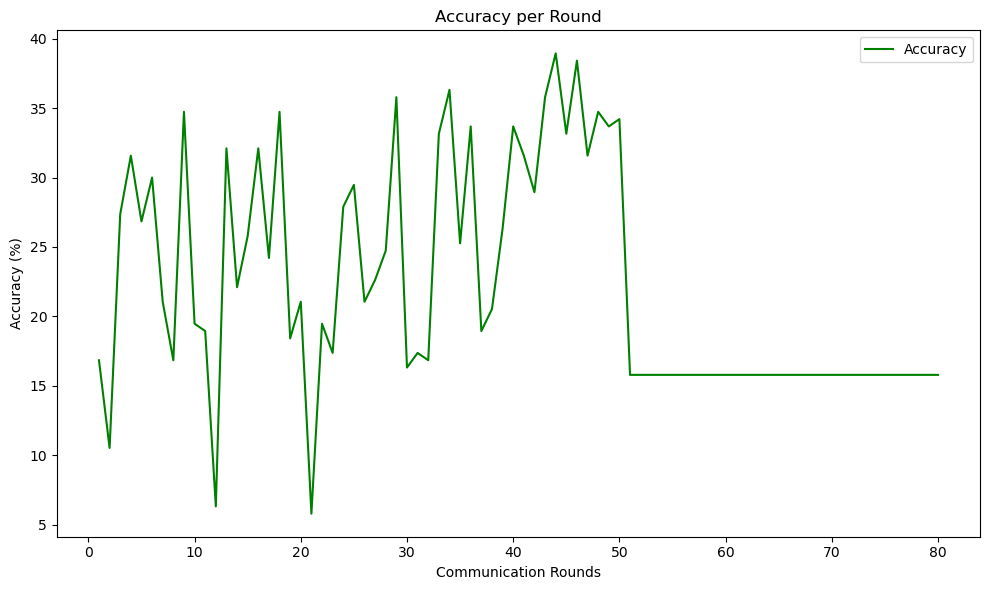

In [15]:
res = np.load("metrics_FedProx_e1_lr1e-2.npz")
plot_metrics(res["avg_local_losses"], res["global_losses"], res["accuracies"], rounds=80)

Data split: Non-IID with 20 users (alpha=0.5).
Round 1/200 starting...
Round 1/200 completed.
 Avg Local Loss: 1.9189
 Global Loss: 2.3027, Accuracy: 12.63%
Round 2/200 starting...
Round 2/200 completed.
 Avg Local Loss: 2.2515
 Global Loss: 2.3013, Accuracy: 10.53%
Round 3/200 starting...
Round 3/200 completed.
 Avg Local Loss: 1.8810
 Global Loss: 2.3115, Accuracy: 5.26%
Round 4/200 starting...
Round 4/200 completed.
 Avg Local Loss: 1.8392
 Global Loss: 2.3146, Accuracy: 10.53%
Round 5/200 starting...
Round 5/200 completed.
 Avg Local Loss: 1.7823
 Global Loss: 2.3169, Accuracy: 5.26%
Round 6/200 starting...
Round 6/200 completed.
 Avg Local Loss: 1.6098
 Global Loss: 2.3626, Accuracy: 10.53%
Round 7/200 starting...
Round 7/200 completed.
 Avg Local Loss: 1.5755
 Global Loss: 2.3397, Accuracy: 4.21%
Round 8/200 starting...
Round 8/200 completed.
 Avg Local Loss: 1.8194
 Global Loss: 2.3214, Accuracy: 21.05%
Round 9/200 starting...
Round 9/200 completed.
 Avg Local Loss: 1.7663
 Glob

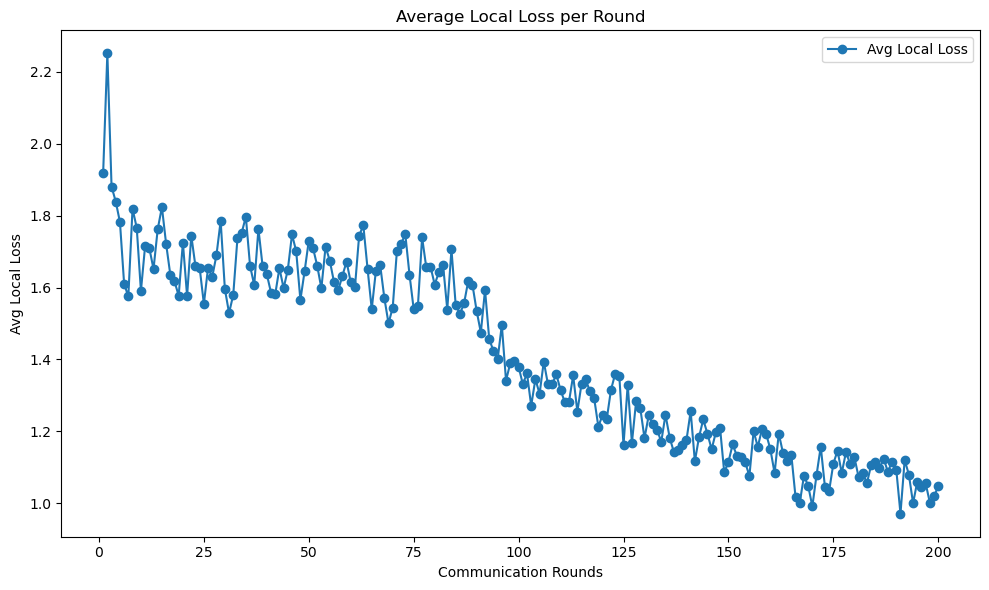

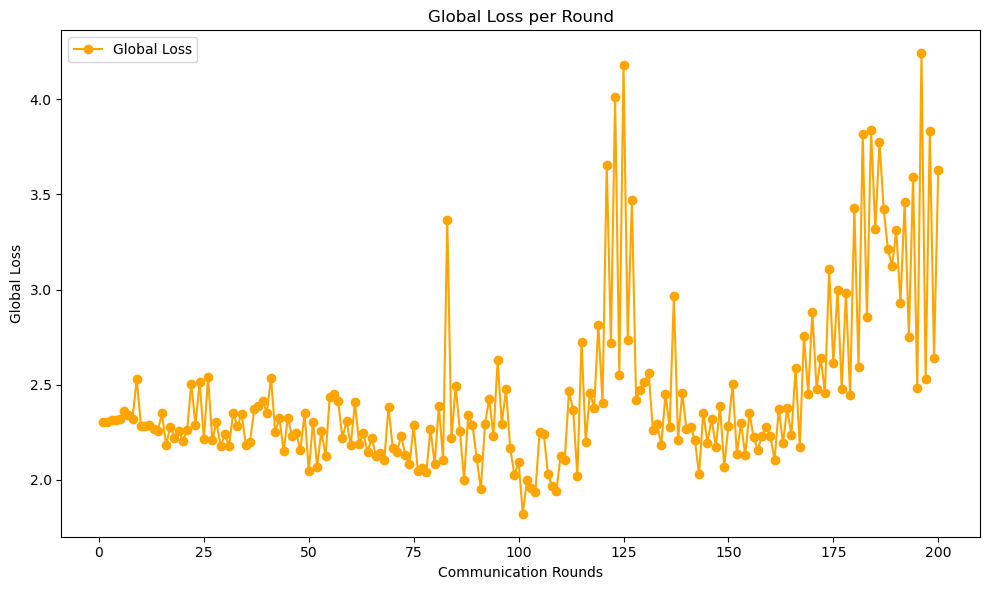

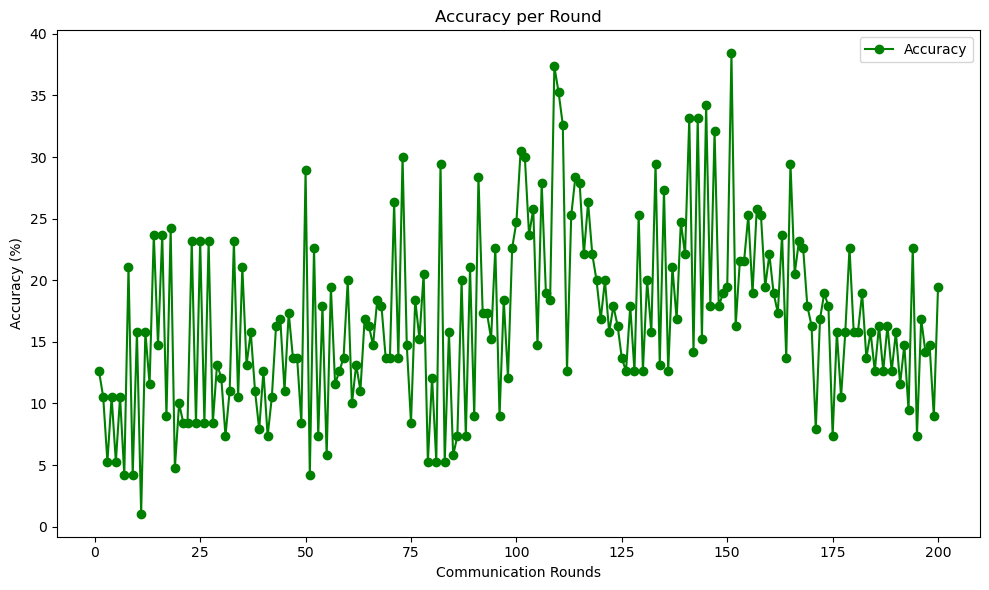

In [20]:
epochs = 5 # 5
learning_rate = 0.01 # 0.01
momentum = 0.5 # 0.9   5/0.01/0.5 → <60%
mu = 0. #
method = 'FedAvgM'

federated_learning_with_scenario(server_class=Server, user_class=User, global_model_class=DanceClsNet, dataset=train_aist, test_loader=test_loader,
        num_users=num_users,
        rounds=rounds,
        epochs=epochs,
        fraction=fraction,
        iid=iid,
        lr=learning_rate,
        alpha=alpha,
        method=method,
        momentum=momentum,
        mu=mu,
        model_kwargs=model_kwargs)

In [ ]:
epochs = 1 #
learning_rate = 0.01 #
momentum = 0. #
mu = 0.005 # 5/0.01/0.01 → 68%, too slow   //   5/0.01/0.001 → 67~68%, too fast
method = 'FedProx'

federated_learning_with_scenario(server_class=Server, user_class=User, global_model_class=DanceClsNet, dataset=train_aist, test_loader=test_loader,
        num_users=num_users,
        rounds=rounds,
        epochs=epochs,
        fraction=fraction,
        iid=iid,
        lr=learning_rate,
        alpha=alpha,
        method=method,
        momentum=momentum,
        mu=mu,
        model_kwargs=model_kwargs)

Data split: Non-IID with 20 users (alpha=0.5).
Round 1/200 starting...
Round 1/200 completed.
 Avg Local Loss: 1.9191
 Global Loss: 2.3498, Accuracy: 16.84%
Round 2/200 starting...
Round 2/200 completed.
 Avg Local Loss: 1.7913
 Global Loss: 2.2751, Accuracy: 10.53%
Round 3/200 starting...
Round 3/200 completed.
 Avg Local Loss: 1.8357
 Global Loss: 2.1804, Accuracy: 27.37%
Round 4/200 starting...
Round 4/200 completed.
 Avg Local Loss: 1.7324
 Global Loss: 2.0131, Accuracy: 31.58%
Round 5/200 starting...
Round 5/200 completed.
 Avg Local Loss: 1.6744
 Global Loss: 2.0148, Accuracy: 26.84%
Round 6/200 starting...
Round 6/200 completed.
 Avg Local Loss: 1.5968
 Global Loss: 2.0451, Accuracy: 30.00%
Round 7/200 starting...
Round 7/200 completed.
 Avg Local Loss: 1.5112
 Global Loss: 2.0901, Accuracy: 21.05%
Round 8/200 starting...
Round 8/200 completed.
 Avg Local Loss: 1.5506
 Global Loss: 2.1003, Accuracy: 16.84%
Round 9/200 starting...
Round 9/200 completed.
 Avg Local Loss: 1.3593
 G

Data split: Non-IID with 20 users (alpha=0.5).
Round 1/200 starting...
Round 1/200 completed.
 Avg Local Loss: 1.8557
 Global Loss: 2.3582, Accuracy: 10.53%
Round 2/200 starting...
Round 2/200 completed.
 Avg Local Loss: 1.6727
 Global Loss: 2.3559, Accuracy: 10.53%
Round 3/200 starting...
Round 3/200 completed.
 Avg Local Loss: 1.7838
 Global Loss: 2.4339, Accuracy: 5.26%
Round 4/200 starting...
Round 4/200 completed.
 Avg Local Loss: 1.6267
 Global Loss: 2.2408, Accuracy: 26.32%
Round 5/200 starting...
Round 5/200 completed.
 Avg Local Loss: 1.7423
 Global Loss: 2.2660, Accuracy: 6.32%
Round 6/200 starting...
Round 6/200 completed.
 Avg Local Loss: 1.5264
 Global Loss: 2.2644, Accuracy: 26.32%
Round 7/200 starting...
Round 7/200 completed.
 Avg Local Loss: 1.5354
 Global Loss: 2.2995, Accuracy: 23.16%
Round 8/200 starting...
Round 8/200 completed.
 Avg Local Loss: 1.7591
 Global Loss: 2.2760, Accuracy: 12.11%
Round 9/200 starting...
Round 9/200 completed.
 Avg Local Loss: 1.6746
 Glo

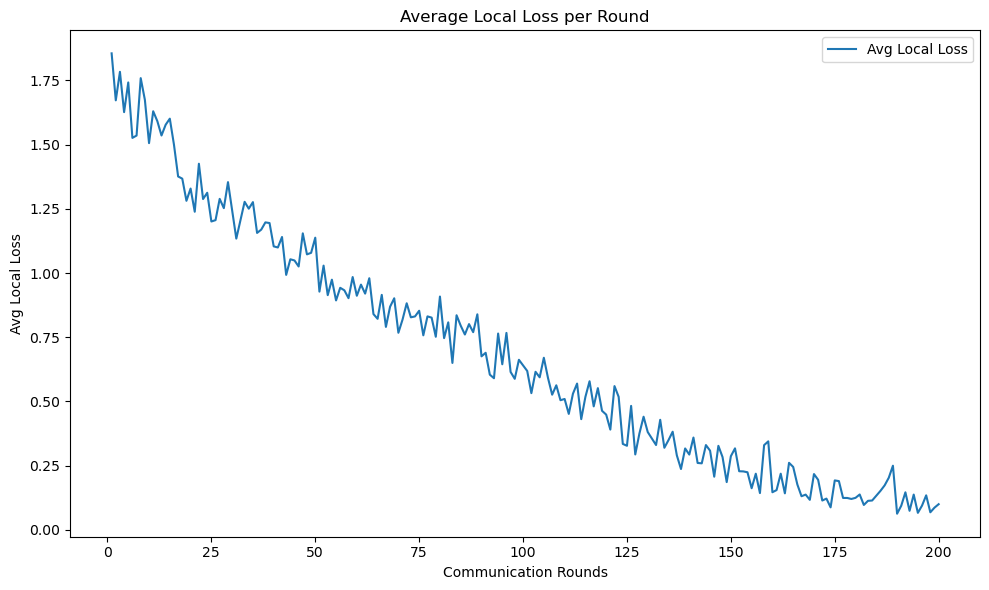

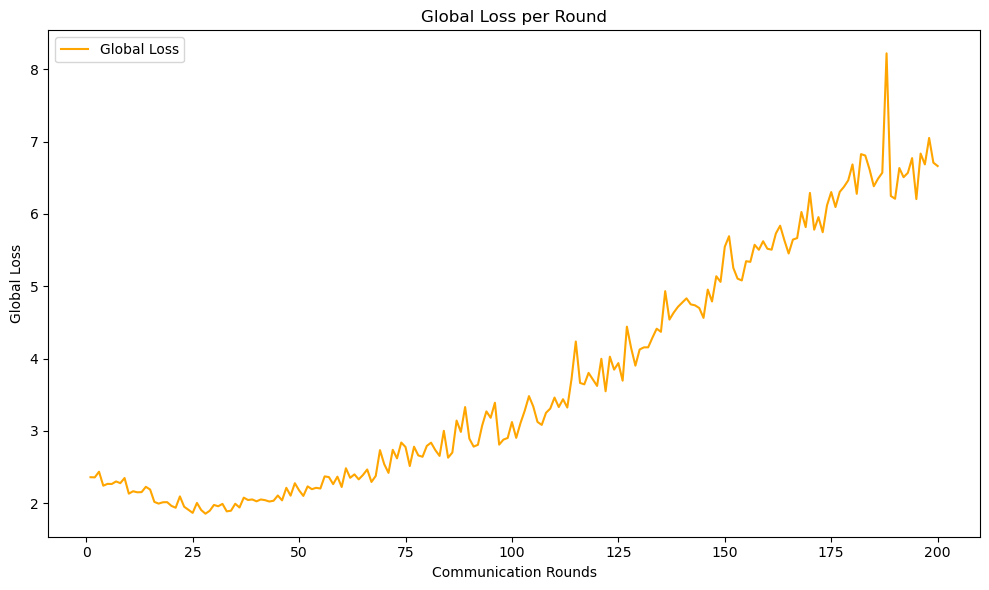

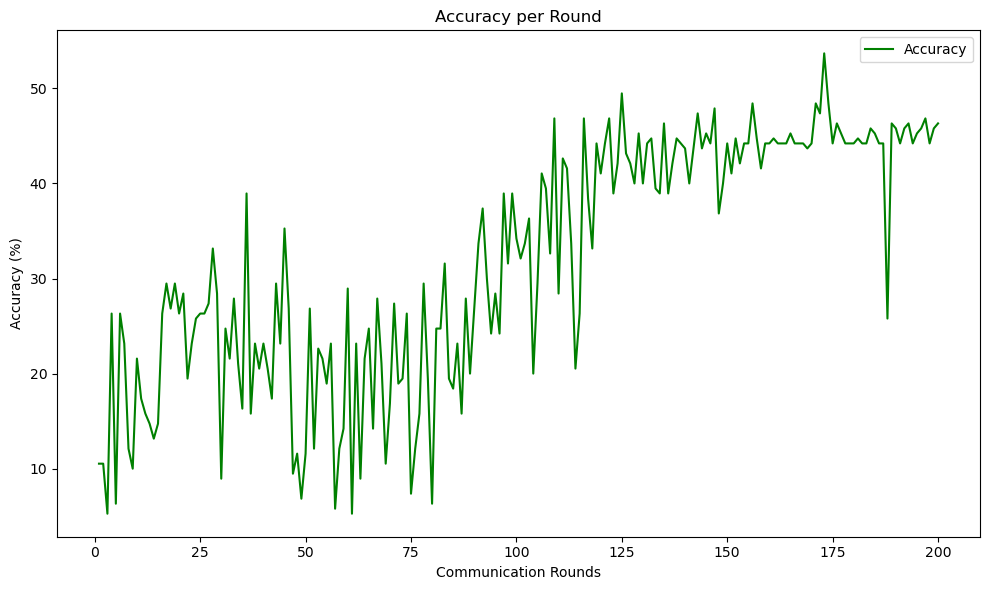

In [11]:
epochs = 1 #
learning_rate = 0.001 #
momentum = 0. #
mu = 0. #
method = 'SCAFFOLD'

federated_learning_with_scenario(server_class=Server, user_class=User, global_model_class=DanceClsNet, dataset=train_aist, test_loader=test_loader,
        num_users=num_users,
        rounds=rounds,
        epochs=epochs,
        fraction=fraction,
        iid=iid,
        lr=learning_rate,
        alpha=alpha,
        method=method,
        momentum=momentum,
        mu=mu,
        model_kwargs=model_kwargs)

Data split: IID with 20 users.
Round 1/200 starting...
Round 1/200 completed.
 Avg Local Loss: 2.3046
 Global Loss: 2.3123, Accuracy: 7.37%
Round 2/200 starting...
Round 2/200 completed.
 Avg Local Loss: 2.2924
 Global Loss: 2.3146, Accuracy: 7.37%
Round 3/200 starting...
Round 3/200 completed.
 Avg Local Loss: 2.2841
 Global Loss: 2.2853, Accuracy: 4.74%
Round 4/200 starting...
Round 4/200 completed.
 Avg Local Loss: 2.2757
 Global Loss: 2.2769, Accuracy: 7.37%
Round 5/200 starting...
Round 5/200 completed.
 Avg Local Loss: 2.2631
 Global Loss: 2.2647, Accuracy: 9.47%
Round 6/200 starting...
Round 6/200 completed.
 Avg Local Loss: 2.2461
 Global Loss: 2.2481, Accuracy: 11.05%
Round 7/200 starting...
Round 7/200 completed.
 Avg Local Loss: 2.2198
 Global Loss: 2.2210, Accuracy: 8.42%
Round 8/200 starting...
Round 8/200 completed.
 Avg Local Loss: 2.1942
 Global Loss: 2.1908, Accuracy: 21.58%
Round 9/200 starting...
Round 9/200 completed.
 Avg Local Loss: 2.1656
 Global Loss: 2.1636, Ac

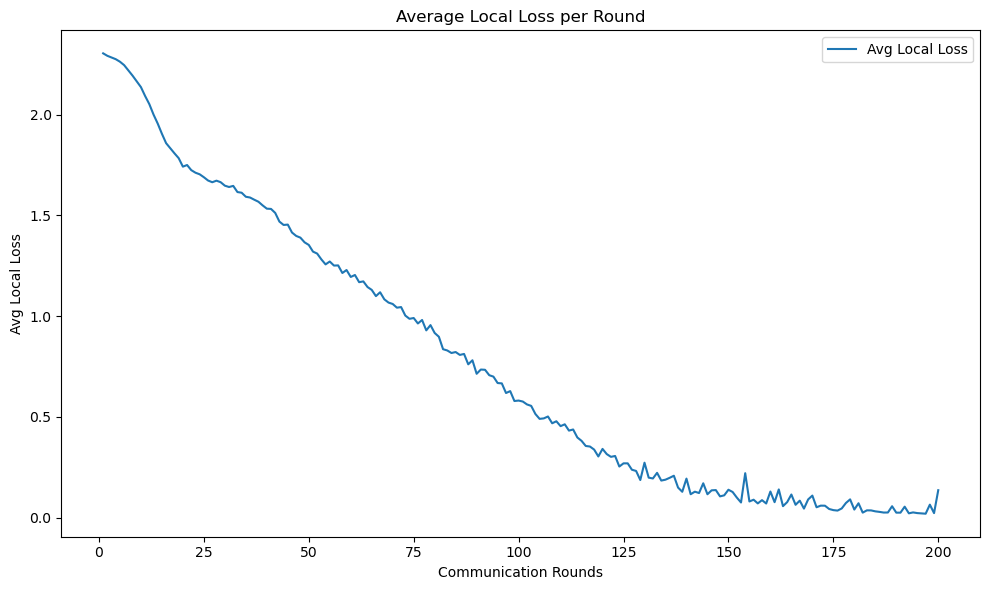

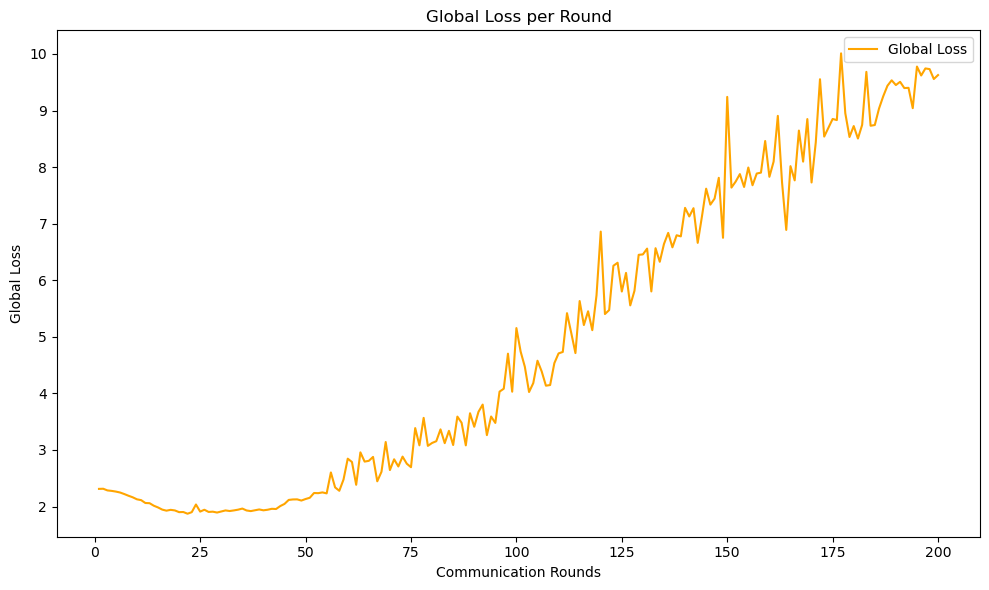

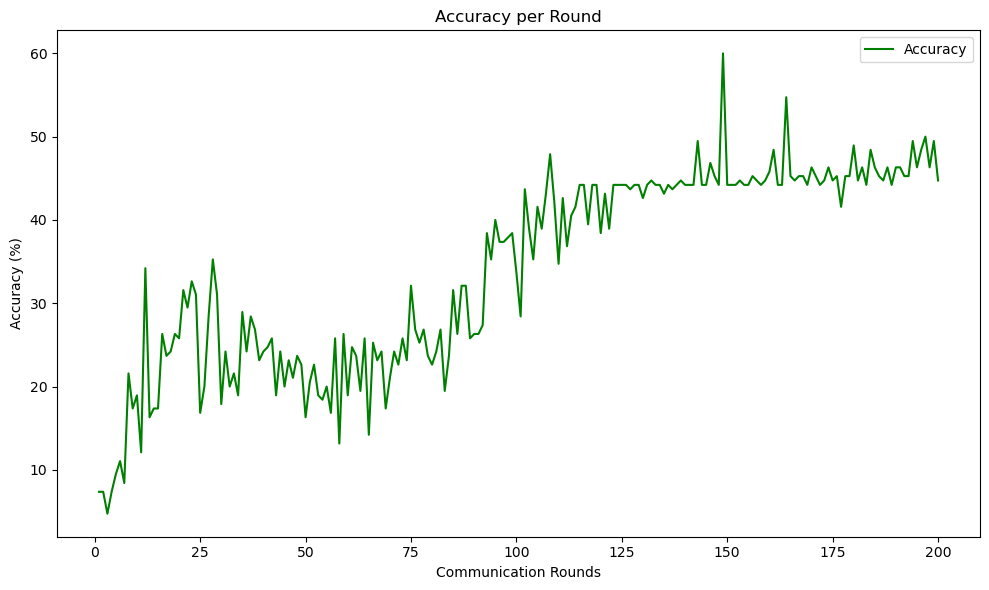

In [13]:
epochs = 1 #
learning_rate = 0.001 #
momentum = 0. #
mu = 0. #
method = 'SCAFFOLD'

federated_learning_with_scenario(server_class=Server, user_class=User, global_model_class=DanceClsNet, dataset=train_aist, test_loader=test_loader,
        num_users=num_users,
        rounds=rounds,
        epochs=epochs,
        fraction=fraction,
        iid=True,
        lr=learning_rate,
        alpha=alpha,
        method=method,
        momentum=momentum,
        mu=mu,
        model_kwargs=model_kwargs)